<a href="https://colab.research.google.com/github/chetan7116desai/TEAM_A_data606/blob/main/FInalModel/ADABoostFinalmodel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Connecting to shared drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# Final Model

In [ ]:
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import  AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
# Modelling - Classification metrics
from sklearn import metrics
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import plot_roc_curve, roc_auc_score
# Vectorizing
from sklearn.feature_extraction.text import TfidfVectorizer
# Column Transformer
from typing import Callable
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.pipeline import Pipeline
import pickle
from sklearn.linear_model import SGDClassifier
import string
import re
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
custom_stopwords = nltk.corpus.stopwords.words('english')

stopword_list = ['moderna', 'flu', 'mrna', 'vaccine', 'the', 'patient', 'pfizer', 
                 'biontech', 'nan', 'none', 'mg', 'medical', 'history', 'allergy', 
                 'year', 'old','uk','nkda','nka','known','reported','listed']

In [ ]:
textTransformer_0 = Pipeline(steps=[
    ('text_bow', TfidfVectorizer(lowercase=True,\
                                 token_pattern=r"(?u)\b\w+\b",\
                                 stop_words=stopword_list,
                                 ngram_range=(2, 2),max_features=5000))])

In [ ]:
tfidfprocess = ColumnTransformer(transformers=[('text1', textTransformer_0, 'SYMPTOM_TEXT'),
                                              ('text2', textTransformer_0, 'OTHER_MEDS'),
                                              ('text3', textTransformer_0, 'CUR_ILL'),
                                              ('text4', textTransformer_0, 'HISTORY'),
                                              ('text5', textTransformer_0, 'ALLERGIES')
],remainder='passthrough')

### covid ADA boost model

In [ ]:
covid_clean =pd.read_csv("/content/drive/Shareddrives/Team A 606 Capstone Project/Dataset/covid_ml.csv*")

In [ ]:
vaccine_data = pd.get_dummies(covid_clean.VAX_MANU)
covid_clean = pd.merge(covid_clean, vaccine_data, left_index=True, right_index=True)


In [ ]:
covid_clean.OTHER_MEDS = covid_clean.OTHER_MEDS.replace(np.nan,'',regex=True)
covid_clean.CUR_ILL = covid_clean.CUR_ILL.replace(np.nan,'',regex=True)
covid_clean.HISTORY = covid_clean.HISTORY.replace(np.nan,'',regex=True)
covid_clean.ALLERGIES = covid_clean.ALLERGIES.replace(np.nan,'',regex=True)

In [ ]:
from sklearn.model_selection import train_test_split

y=covid_clean.serious
X=covid_clean.drop(['serious','SYMPTOM1','SYMPTOM2','SYMPTOM3','SYMPTOM4',
                    'SYMPTOM5','VAX_MANU'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, 
                                                    random_state=200, stratify=y)

print(f'Training examples: {X_train.shape[0]:,}')
print(f'Test examples: {X_test.shape[0]:,}')

Training examples: 694,303
Test examples: 297,559


In [ ]:
%%time
covid_lg_pipe = Pipeline([
    ('preproc', tfidfprocess),
    ('ada', AdaBoostClassifier(DecisionTreeClassifier(),n_estimators=50))])

covid_lg_pipe.fit(X_train, y_train)
y_pred = covid_lg_pipe.predict(X_test)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
# Print results
print(f'Train score (Accuracy): {covid_lg_pipe.score(X_train, y_train):.3f}, Test score (Accuracy): {covid_lg_pipe.score(X_test, y_test):.3f}')
print(f'Recall: {tp/(tp+fn):.3f}, F1 score (test): {tp/(tp+(fp+fn)/2):.3f}, Specificity: {tn/(tn+fp):.3f}, Precision: {tp/(tp+fp):.3f}')

Train score (Accuracy): 0.988, Test score (Accuracy): 0.946
Recall: 0.622, F1 score (test): 0.701, Specificity: 0.983, Precision: 0.803
CPU times: user 4min 51s, sys: 304 ms, total: 4min 51s
Wall time: 4min 50s


<Figure size 432x432 with 0 Axes>

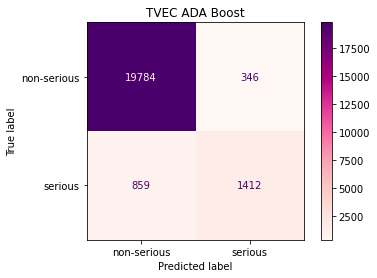

In [ ]:
plt.figure(figsize=(6,6))        

# Confusion Matrix



plot_confusion_matrix(covid_lg_pipe, 
                      X_test, y_test, 
                      cmap='RdPu', 
                      values_format='d',
                      display_labels=['non-serious', 'serious']
                     );
plt.title('TVEC ADA Boost');

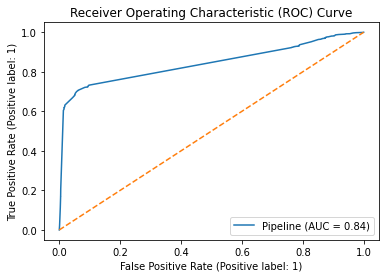

In [ ]:
plot_roc_curve(covid_lg_pipe, X_test, y_test)

# add worst case scenario line
plt.plot([0,1], [0,1], label = "baseline", linestyle = "--")

# add title
plt.title('Receiver Operating Characteristic (ROC) Curve');

In [ ]:
with open(f'/content/drive/Shareddrives/Team A 606 Capstone Project/Code/covid_ada_new_model.sav', 'wb') as f:
    pickle.dump(covid_lg_pipe, f)

### Flu model

In [ ]:
flu_clean =pd.read_csv("/content/drive/Shareddrives/Team A 606 Capstone Project/Dataset/flu_ml.csv")

In [ ]:
vaccine_data = pd.get_dummies(flu_clean.VAX_MANU)
flu_clean = pd.merge(flu_clean, vaccine_data, left_index=True, right_index=True)
flu_clean.rename(columns = {'PARKE-DAVIS' : 'PARKE','CONNAUGHT LABORATORIES' : 'CONNAUGHT',
             'LEDERLE LABORATORIES' : 'LEDERLE' ,'PFIZER\WYETH' : 'PFIZER',
              'MEDEVA PHARMA, LTD.' : 'MEDEVA','PARKDALE PHARMACEUTICALS' : 'PARKDALE',
               'SANOFI PASTEUR' : 'SANOFI' ,'MEDIMMUNE VACCINES, INC.' : 'MEDIMMUNE',
                'EVANS VACCINES' :'EVANS' ,'GLAXOSMITHKLINE BIOLOGICALS' : 'GLAXOSMITHKLINE', 
                 'NOVARTIS VACCINES AND DIAGNOSTICS' : 'NOVARTIS',
                'CSL LIMITED' : 'CSL','PROTEIN SCIENCES CORPORATION' : 'PROTEIN',
                 'SEQIRUS, INC.' : 'SEQIRUS', 'AVENTIS PASTEUR' :'AVENTIS' }, inplace = True)

In [ ]:

flu_clean.OTHER_MEDS = flu_clean.OTHER_MEDS.replace(np.nan,'',regex=True)
flu_clean.CUR_ILL = flu_clean.CUR_ILL.replace(np.nan,'',regex=True)
flu_clean.HISTORY = flu_clean.HISTORY.replace(np.nan,'',regex=True)
flu_clean.ALLERGIES = flu_clean.ALLERGIES.replace(np.nan,'',regex=True)

In [ ]:
from sklearn.model_selection import train_test_split

y=flu_clean.serious
X=flu_clean.drop(['serious','SYMPTOM1','SYMPTOM2','SYMPTOM3','SYMPTOM4',
                    'SYMPTOM5','VAX_MANU'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, 
                                                    random_state=200, stratify=y)

print(f'Training examples: {X_train.shape[0]:,}')
print(f'Test examples: {X_test.shape[0]:,}')

Training examples: 123,561
Test examples: 52,956


In [ ]:
%%time
flu_ada_pipe = Pipeline([
    ('preproc', tfidfprocess),
    ('ada', AdaBoostClassifier(DecisionTreeClassifier()))])

flu_ada_pipe.fit(X_train, y_train)
y_pred = flu_ada_pipe.predict(X_test)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
# Print results
print(f'Train score (Accuracy): {flu_ada_pipe.score(X_train, y_train):.3f}, Test score (Accuracy): {flu_ada_pipe.score(X_test, y_test):.3f}')
print(f'Recall: {tp/(tp+fn):.3f}, F1 score (test): {tp/(tp+(fp+fn)/2):.3f}, Specificity: {tn/(tn+fp):.3f}, Precision: {tp/(tp+fp):.3f}')

Train score (Accuracy): 0.986, Test score (Accuracy): 0.908
Recall: 0.755, F1 score (test): 0.769, Specificity: 0.947, Precision: 0.783
CPU times: user 17min 21s, sys: 1.02 s, total: 17min 22s
Wall time: 17min 17s


<Figure size 432x432 with 0 Axes>

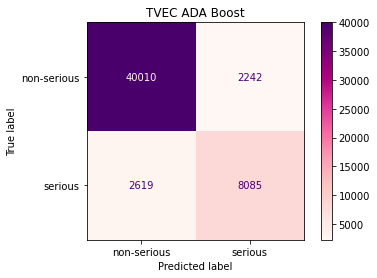

In [ ]:
plt.figure(figsize=(6,6))        

# Confusion Matrix



plot_confusion_matrix(flu_ada_pipe, 
                      X_test, y_test, 
                      cmap='RdPu', 
                      values_format='d',
                      display_labels=['non-serious', 'serious']
                     );
plt.title('TVEC ADA Boost');

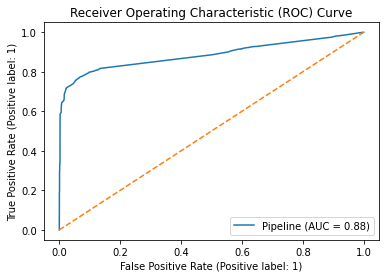

In [ ]:
plot_roc_curve(flu_ada_pipe, X_test, y_test)

# add worst case scenario line
plt.plot([0,1], [0,1], label = "baseline", linestyle = "--")

# add title
plt.title('Receiver Operating Characteristic (ROC) Curve');

In [ ]:
with open(f'/content/drive/Shareddrives/Team A 606 Capstone Project/Code/flu_new_ada__model.sav', 'wb') as f:
    pickle.dump(flu_ada_pipe, f)

### Hep model

In [ ]:
hep_clean =pd.read_csv("/content/drive/Shareddrives/Team A 606 Capstone Project/Dataset/hep_ml.csv")

In [ ]:
vaccine_data = pd.get_dummies(hep_clean.VAX_MANU)
hep_clean = pd.merge(hep_clean, vaccine_data, left_index=True, right_index=True)
hep_clean.rename(columns = {'GLAXOSMITHKLINE BIOLOGICALS':'GLAXOSMITHKLINE','MERCK & CO. INC.': 'MERCK',
                              'DYNAVAX TECHNOLOGIES CORPORATION' : 'DYNAVAX','SANOFI PASTEUR' : 'SANOFI','SMITHKLINE BEECHAM':'SMITHKLINE' }, inplace = True)


In [ ]:
hep_clean.OTHER_MEDS = hep_clean.OTHER_MEDS.replace(np.nan,'',regex=True)
hep_clean.CUR_ILL = hep_clean.CUR_ILL.replace(np.nan,'',regex=True)
hep_clean.HISTORY = hep_clean.HISTORY.replace(np.nan,'',regex=True)
hep_clean.ALLERGIES = hep_clean.ALLERGIES.replace(np.nan,'',regex=True)

In [ ]:
from sklearn.model_selection import train_test_split

y=hep_clean.serious
X=hep_clean.drop(['serious','SYMPTOM1','SYMPTOM2','SYMPTOM3','SYMPTOM4',
                    'SYMPTOM5','VAX_MANU'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, 
                                                    random_state=200, stratify=y)

print(f'Training examples: {X_train.shape[0]:,}')
print(f'Test examples: {X_test.shape[0]:,}')

Training examples: 64,673
Test examples: 27,717


In [ ]:
%%time
hp_ada_pipe = Pipeline([
    ('preproc', tfidfprocess),
    ('ada', AdaBoostClassifier(DecisionTreeClassifier()))])

hp_ada_pipe.fit(X_train, y_train)
y_pred = hp_ada_pipe.predict(X_test)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
# Print results
print(f'Train score (Accuracy): {hp_ada_pipe.score(X_train, y_train):.3f}, Test score (Accuracy): {hp_ada_pipe.score(X_test, y_test):.3f}')
print(f'Recall: {tp/(tp+fn):.3f}, F1 score (test): {tp/(tp+(fp+fn)/2):.3f}, Specificity: {tn/(tn+fp):.3f}, Precision: {tp/(tp+fp):.3f}')

Train score (Accuracy): 0.982, Test score (Accuracy): 0.870
Recall: 0.820, F1 score (test): 0.801, Specificity: 0.893, Precision: 0.782
CPU times: user 5min 37s, sys: 452 ms, total: 5min 37s
Wall time: 5min 36s


<Figure size 432x432 with 0 Axes>

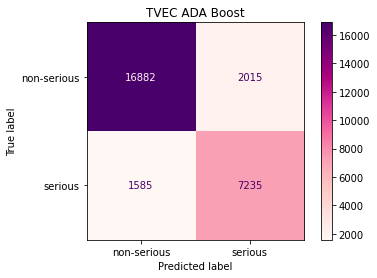

In [ ]:
plt.figure(figsize=(6,6))        

# Confusion Matrix



plot_confusion_matrix(hp_ada_pipe, 
                      X_test, y_test, 
                      cmap='RdPu', 
                      values_format='d',
                      display_labels=['non-serious', 'serious']
                     );
plt.title('TVEC ADA Boost');

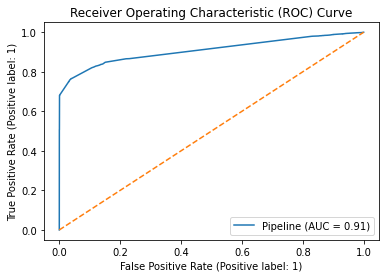

In [ ]:
plot_roc_curve(hp_ada_pipe, X_test, y_test)

# add worst case scenario line
plt.plot([0,1], [0,1], label = "baseline", linestyle = "--")

# add title
plt.title('Receiver Operating Characteristic (ROC) Curve');

In [ ]:
with open(f'/content/drive/Shareddrives/Team A 606 Capstone Project/Code/hp_new_ada_model.sav', 'wb') as f:
    pickle.dump(hp_ada_pipe, f)

### Varzos model

In [ ]:
varzos_clean =pd.read_csv("/content/drive/Shareddrives/Team A 606 Capstone Project/Dataset/var_ml.csv")

In [ ]:
vaccine_data = pd.get_dummies(varzos_clean.VAX_MANU)
varzos_clean = pd.merge(varzos_clean, vaccine_data, left_index=True, right_index=True)
varzos_clean.rename(columns = {'GLAXOSMITHKLINE BIOLOGICALS':'GLAXOSMITHKLINE','MERCK & CO. INC.': 'MERCK'}, inplace = True)


In [ ]:
varzos_clean.rename(columns = {'GLAXOSMITHKLINE BIOLOGICALS':'GLAXOSMITHKLINE','MERCK & CO. INC.': 'MERCK'}, inplace = True)


In [ ]:
varzos_clean.OTHER_MEDS = varzos_clean.OTHER_MEDS.replace(np.nan,'',regex=True)
varzos_clean.CUR_ILL = varzos_clean.CUR_ILL.replace(np.nan,'',regex=True)
varzos_clean.HISTORY = varzos_clean.HISTORY.replace(np.nan,'',regex=True)
varzos_clean.ALLERGIES = varzos_clean.ALLERGIES.replace(np.nan,'',regex=True)

In [ ]:
from sklearn.model_selection import train_test_split

y=varzos_clean.serious
X=varzos_clean.drop(['serious','SYMPTOM1','SYMPTOM2','SYMPTOM3','SYMPTOM4',
                    'SYMPTOM5','VAX_MANU'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, 
                                                    random_state=200, stratify=y)

print(f'Training examples: {X_train.shape[0]:,}')
print(f'Test examples: {X_test.shape[0]:,}')

Training examples: 52,269
Test examples: 22,401


In [ ]:
%%time
var_ada_pipe = Pipeline([
    ('preproc', tfidfprocess),
    ('ada', AdaBoostClassifier(DecisionTreeClassifier()))])

var_ada_pipe.fit(X_train, y_train)
y_pred = var_ada_pipe.predict(X_test)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
# Print results
print(f'Train score (Accuracy): {var_ada_pipe.score(X_train, y_train):.3f}, Test score (Accuracy): {var_ada_pipe.score(X_test, y_test):.3f}')
print(f'Recall: {tp/(tp+fn):.3f}, F1 score (test): {tp/(tp+(fp+fn)/2):.3f}, Specificity: {tn/(tn+fp):.3f}, Precision: {tp/(tp+fp):.3f}')

Train score (Accuracy): 0.988, Test score (Accuracy): 0.946
Recall: 0.636, F1 score (test): 0.705, Specificity: 0.981, Precision: 0.791
CPU times: user 4min 34s, sys: 316 ms, total: 4min 34s
Wall time: 4min 33s


<Figure size 432x432 with 0 Axes>

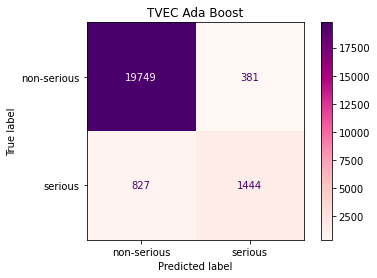

In [ ]:
plt.figure(figsize=(6,6))        

# Confusion Matrix



plot_confusion_matrix(var_ada_pipe, 
                      X_test, y_test, 
                      cmap='RdPu', 
                      values_format='d',
                      display_labels=['non-serious', 'serious']
                     );
plt.title('TVEC Ada Boost');

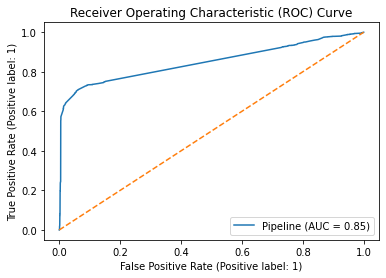

In [ ]:
plot_roc_curve(var_ada_pipe, X_test, y_test)

# add worst case scenario line
plt.plot([0,1], [0,1], label = "baseline", linestyle = "--")

# add title
plt.title('Receiver Operating Characteristic (ROC) Curve');

In [ ]:
with open(f'/content/drive/Shareddrives/Team A 606 Capstone Project/Code/var_new_ada_model.sav', 'wb') as f:
    pickle.dump(var_ada_pipe, f)